In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from src.models.feature.GooLeNet import GoogLeNet
from src.models.feature.ResNet import ResNet18
from src.models.module.pooling import GVAP, GAP

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

#class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

model = ResNet18(classes=len(class_name),alpha=0, cal='plus').to(device)

model.load_state_dict(torch.load('./pretrain/resnet18_stl10_gap_model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [3]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (relu2): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1):

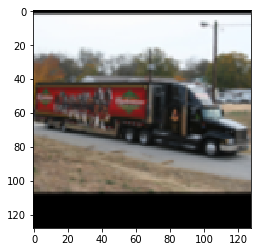

In [25]:
img_path = './test_img/stl10/test1.png'

img = Image.open(img_path)

plt.imshow(img)

In [26]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor()])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 128, 128)

In [27]:
gradients = []

def save_gradient(grad):
    gradients.append(grad)
    
datas = Variable(tensor_img, requires_grad=True)

feature = datas[0].unsqueeze(0)

In [28]:
tensor_img.shape

torch.Size([1, 3, 128, 128])

In [29]:
for name, module in model.named_children():
    print(feature.shape)
    if name == 'dense1':
        feature = feature.view(feature.size(0), -1)
    feature = module(feature)
    if name == 'Block4':
        feature.register_hook(save_gradient)
        final_conv = feature
        print(feature.shape)
        feature = torch.mean(feature, [2, 3])

torch.Size([1, 3, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512])


In [30]:
final_conv

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.4626e-01, 4.1432e-01, 3.7715e-01, 1.3199e-01],
          [8.5202e-01, 2.6117e+00, 2.6625e+00, 1.9784e+00],
          [6.1013e-01, 1.4102e+00, 1.4511e+00, 1.4269e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3496e-02, 3.0879e-01, 2.6755e-01, 6.9982e-01]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

         ...,

         [[5.7043e-01, 1.1752e+00, 8.9304e-01, 2.7685e-01],
          [6.2821e-01, 1.3207e+00, 1.1283e+00, 4.0332e-01],
          [0.0000e+00, 3.2801e-01, 1.5407e-01, 0.0000e+00],
          [2.1978e-03, 2.2178e-01, 0.0000e+00, 0.0000e+00]],

         [[4.3280

In [31]:
target = np.argmax(feature.cpu().data.numpy())

In [32]:
one_hot_output = torch.cuda.FloatTensor(1, feature.size()[-1]).zero_()

In [33]:
one_hot_output[0][target] = 1

In [34]:
feature.backward(gradient=one_hot_output, retain_graph=True)

In [35]:
final_conv = final_conv.squeeze(0)

weight = gradients[0].mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
weights = torch.mean(gradients[0], [0,2,3]).cpu().numpy()

activations = final_conv.detach().cpu().numpy()

In [36]:
weight.shape, weights.shape

(torch.Size([1, 512, 1, 1]), (512,))

In [37]:
from torch.nn import functional as F

mask = F.relu((weight * final_conv).sum(dim=1)).squeeze(0)
mask = mask.detach().cpu().numpy()

print(mask)

[[0.4248355  0.6898007  0.6847503  0.48632893]
 [0.90578496 1.480297   1.4318707  0.88299215]
 [1.368229   2.275868   2.257207   1.4735696 ]
 [0.42976394 0.9015561  0.95390654 0.5289583 ]]


In [38]:
cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i,w in enumerate(weights):
    cam += w*activations[i,:,:]
    
print()

In [40]:
def scaling(cam):
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    return cam

In [41]:
cam = scaling(cam)
mask = scaling(mask)

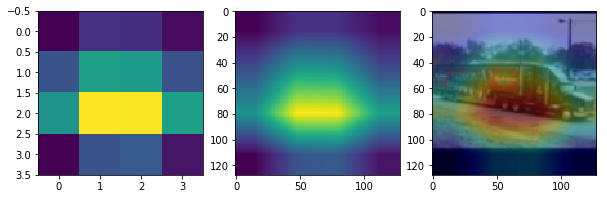

In [43]:
import cv2

fig, axs = plt.subplots(1, 3, figsize=(10,10))

axs[0].imshow(cam)

resized_cam = cv2.resize(cam, (128, 128))

axs[1].imshow(resized_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * resized_cam), cv2.COLORMAP_JET)

img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))
heatimg = heatmap*0.3 + img*0.5
cv2.imwrite('./cam.jpg', heatimg)

cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

axs[2].imshow(cam_img)